<a href="https://colab.research.google.com/github/dijkstra001/py-for-data/blob/main/py_for_data_case05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Utilização de Python para Análise de Dados: Caso prático - 05**

---

O conteúdo apresentado a seguir tem como objetivo criar cenários práticos e de uso geral onde a linguagem Python pode nos auxiliar de forma rápida e simples na análise de dados.

Esse material tem como objetivo ensinar algumas práticas para facilitar a análise de dados, não focando em técnicas complexas e de uso exclusivo para determinada situação.

O conteúdo tem como base o Livro **Python para Análise de Dados** (Wes McKinney, NOVATEC) e **Data Science do Zero** (Joel Grus, O'Reilly).

### **Extraíndo dados da internet:**



In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import locale
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### **Conjunto de dados:**

Vamos utilizar o conjunto de dados disponível no site: https://www.valor.srv.br/indices/inpc.php, onde vamos analisar os INPC ao longo do tempo.

Importante destacar que vamos realizar a coleta dos dados através de web scraping e é sempre indispensável analisar o arquivo robots.txt. Nele, vão estar descritos os parâmetros que precisamos respeitar na hora de realizar a busca, além, é claro, se é permitido realizar tal tarefa.

No site em questão, até o momento do desenvolvimento desse exemplo, não foi identificado esse arquivo sobre quaisquer restrições.
Vamos nos limitar a buscar apenas **1 página** de dados.

In [2]:
# Realizando a requisição:
request = requests.get('https://www.valor.srv.br/indices/inpc.php').text

# Transformando em um objeto BeautifulSoup:
data = BeautifulSoup(request, 'html.parser')

In [3]:
# Analisando as informações no site, os dados de interesse estão dentro de tags <td's>:

# Filtrando apenas os dados de INPC:
dataset_desnormalizado = data.find_all('td')

# Mostrando as 5 primeiras linhas:
dataset_desnormalizado[:5]

[<td align="center" alt="Maio de 2021" title="Maio de 2021">
 							Mai/2021						</td>,
 <td align="center" alt="INPC de Maio de 2021: 0,96%" title="INPC de Maio de 2021: 0,96%">
 							0,96						</td>,
 <td align="center" alt="INPC acumulada no ano de 2021 (até Maio de 2021): 3,3316%" title="INPC acumulada no ano de 2021 (até Maio de 2021): 3,3316%">
 							3,3316						</td>,
 <td align="center" alt="INPC acumulada nos últimos 12 meses: 8,8962%" title="INPC acumulada nos últimos 12 meses: 8,8962%">
 							8,8962						</td>,
 <td align="center" alt="Abril de 2021" title="Abril de 2021">
 							Abr/2021						</td>]

In [4]:
# Realizando a contrução do nosso dataset normalizado:
dados = []

for i in dataset_desnormalizado[:140]:
  dados.append(i.get_text())

copia = dados.copy()
dados.clear()

for i in copia:
  i = i.replace('\n', '')
  i = i.replace('\t', '')
  dados.append(i)

data = 0
perc = 1
perc_acum_ano = 2
perc_acum_12_meses = 3

v_data = []
v_ano = []
v_perc = []
v_perc_acum = []
v_perc_12 = []

dataset = pd.DataFrame()

# adicionado o .strip("['']") para remover os colchetes e transformar os dados em string. Em sequência, convertemos para float.

for i in dados:
  mes_ano = str(dados[data: data + 1]).lower().strip("['']")
  ano = re.sub('[^0-9]', '', str(dados[data: data + 1]).lower().strip("['']"))
  percentual = float(str(dados[perc: perc + 1]).strip("['']").replace(',', '.'))
  percentual_acumulado = float(str(dados[perc_acum_ano: perc_acum_ano + 1]).strip("['']").replace(',', '.'))
  percentual_12_meses = float(str(dados[perc_acum_12_meses: perc_acum_12_meses + 1]).strip("['']").replace(',', '.'))
  
  v_data.append(mes_ano)
  v_ano.append(ano)
  v_perc.append(percentual)
  v_perc_acum.append(percentual_acumulado)
  v_perc_12.append(percentual_12_meses)

  data += 4
  perc += 4 
  perc_acum_ano += 4 
  perc_acum_12_meses += 4 

  if data + 1 >= len(dados):
    break

dataset['mes_ano'] = v_data
dataset['ano'] = v_ano
dataset['percentual'] = v_perc
dataset['perc_acum_ano'] = v_perc_acum
dataset['perc_acum_12_meses'] = v_perc_12

In [5]:
dataset.head(6)

,mes_ano,ano,percentual,perc_acum_ano,perc_acum_12_meses
0,mai/2021,2021,0.96,3.3316,8.8962
1,abr/2021,2021,0.38,2.3491,7.5911
2,mar/2021,2021,0.86,1.9616,6.9373
3,fev/2021,2021,0.82,1.0922,6.2163
4,jan/2021,2021,0.27,0.2700,5.5315
5,dez/2020,2020,1.46,5.4473,5.4473


### **Realizando o processo de análise dos dados**:###



In [6]:
# Calcular o acumulado dos anos:
ds_acum = pd.DataFrame()
ds_acum[['ano', 'percentual']] = dataset[['ano', 'percentual']]

ds_acum['acum'] = ds_acum.groupby(['ano']).cumsum()
ds_acum.head()

,ano,percentual,acum
0,2021,0.96,0.96
1,2021,0.38,1.34
2,2021,0.86,2.20
3,2021,0.82,3.02
4,2021,0.27,3.29


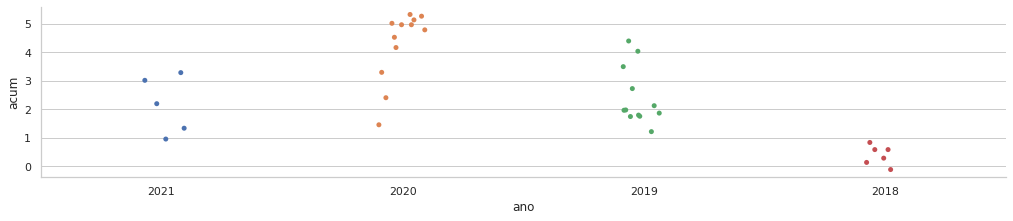

In [7]:
# Plotar um gráfico com os valores acumulados:
sns.set_theme(style="whitegrid")
plot = sns.catplot(x="ano", y="acum", estimator=sum, ci=None, data=ds_acum, height=3, aspect=14/3)

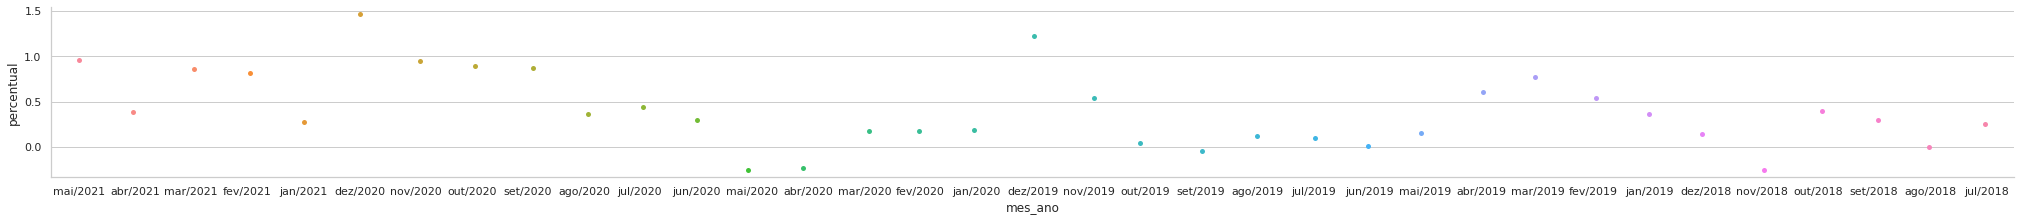

In [8]:
# Plotar um gráfico com os valores ao longo dos meses:
plot = sns.catplot(x="mes_ano", y="percentual", estimator=sum, ci=None, data=dataset, height=3, aspect=28/3)